In this lecture we continue to study manifold learning techniques. 

Multidimensional scaling (MDS) is a method that is more fit for linear embeddings, which, as we described in previous lecture,  consist of fundamental geometric operations such as rotations, translations, and scalings of data into higher-dimensional spaces. Where MDS breaks down is when the embedding is nonlinear, i.e., when it goes beyond this simple set of operations. 

In this module we go over some of the nonlinear manifold learning techniques, including Isomap, local linear embedding (LLE), and Hessian Eigenmapping (HE). Before we visit these algorithms in details, let's review some basics on Riemann manifold.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from matplotlib import offsetbox
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
#from sklearn.decomposition import RandomizedPCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from mpl_toolkits import mplot3d

%matplotlib inline

### I. Theories on Manifold Learning

We will follow the text by Izenman (2008) "Modern Multivariate Statistical Techniques: Regression, Classficiation, and Manifold Learning" for the theory explanation. To fully understand nonlinear manifold learning, let's first go over some concepts in differential geometry:

##### Definition:
In graph theory, the distance between two vertices in a graph $\mathcal{G}$ is the number of edges in a shortest path connecting them. This is also known as the **geodesic distance**.

##### Definition:
A 1-D **curve** is a function $f: \Lambda \longrightarrow \mathbb{R}^{K}$, $\Lambda \subseteq \mathbb{R}$ so that $f$ itself is a vector-valued function. If the coordinate function of $f$ is smoooth ($f_{k}(\lambda) \in C^{\infty}$), the the curve is **smooth**. $f$ is **closed** iff it's periodic, that is to say, $f(t+\lambda)=f(\lambda)$ $\forall t, \lambda \in \Lambda$. 

##### Definition:
Let $f: \Lambda \longrightarrow \mathbb{R}^{K}$, $\Lambda \subseteq \mathbb{R}$ be a 1-D curve. The **velocity** or **tangent vector** at point $\lambda$ is defined as $f'(\lambda)$. The length of the velocity vector is called the **speed** of the curve at point $\lambda$ and is defined as $|| f'(\lambda)|| = \sqrt{(\sum_{k=1}^{K}(f_{k}'(\lambda))^{2}}$ (Euclidean norm). If the speed is never zero at any $\lambda$, then the curve is called a **regular curve**. The **acceleration vector** of $f$ is defined as  $f''(\lambda)$.

##### Definition:
Let $f: \Lambda \longrightarrow \mathbb{R}^{K}$, $\Lambda \subseteq \mathbb{R}$ be a 1-D curve. The **arc length** along the curve $f$ from point $\lambda_{0}$ to $\lambda_{1}$ is defined as $AL(f)=\int_{\lambda_{1}}^{\lambda_{0}}||f'(\lambda)||d \lambda$. If two curves have the same length, they are said to be **isometric**. 

##### Definition:
A **Riemann manifold** is a pair $(\mathcal{M}, \rho(.))$ where $\mathcal{M}$ is a smooth manifold and $\rho(.)$ is an endowed metric function. If $\mathcal{M}$ is a connected set, then this forms a metric space. And we define $\rho(y_{1}, y_{2})=inf(AL(f)|f:\Lambda \longrightarrow \mathbb{R}^{K} \text{ is a curve joining } y_{1}, y_{2} \in \mathcal{M})$ (this means the metric defines the shortest/geodesic distance between 2 points on the manifold).

##### Nash Embedding Theorem:
We can embed a smooth manifold to a high-dimensional Euclidean space. 

The problem of manifold learning can be summarized in the following way: suppose there exists a random sample of points $y_{i}$ from a smooth r-dimensional manifold $\mathcal{M}$ ($r<K$) with the metric function $\rho(.)$ so that $y_{i} \in \mathcal{M}$ and $dim(\mathcal{M})=r$. These points are embedded in a nonlinear fashion by a smooth map $\varphi$ into a high dimensional input space $\mathcal{X} \subseteq \mathbb{R}^{K}$ with Euclidean metric $||.||$. This embedding yields the input data $x_{i}$. Thus $\varphi: \mathcal{M} \longrightarrow \mathcal{X}$ is the embedding map where $x \in \mathcal{X}$, and a point on the manifold $y_{i} \in \mathcal{M}$ can be expressed as $y_{i}=\varphi^{-1}(x_{i})$. The goal is to recover $\mathcal{M}$ and find an implicit representation of the map $\varphi$ (and hence recover $y_{i}$) given $x_{i} \in \mathcal{X}$. Notation-wise, we let $y_{i}$ be a column vector of size $r$ so $y_{i}=(y_{1i},...y_{ri})'$. Let $x_{i}$ be a column vector of size $K$ so $x_{i}=(x_{1i},...x_{Ki})'$.

### II. Isomap

The isometric feature mapping, also known as Isomap, is a global-approach algorithm that extends the MDS algorithm. The algorithm attempts to preserve the global geometry propertyies of the underlying nonlinear manifoild, and it does this by approximating all geodesic distances (lengths of the shortest paths) on the manifold. The Isomap algorithm requires the following assumptions:

##### Assumptions:
   1. Convexity: the manifold $\mathcal{M}$ is a convex subset of $\mathbb{R}^{r}$
   2. Isometry: the geodesic distance is invariant under the map $\varphi$. For any pair of points on the manifold $y_{1}, y_{2} \in \mathcal{M}$, the geodesic distance between those points equals the Euclidean distance between their corresponding coordinates $x_{1}, x_{2} \in \mathcal{X}$, that is to say, $\rho(y_{1},y_{2})=||x_{1}-x_{2}||$ where $\varphi: \mathcal{M} \longrightarrow \mathcal{X}$.

Essentially, if imagine in a nonlinear setting, Euclidean distance may be a poor measure of dissimilarity between points. So instead of directly employing Euclidean distance to compute the distance matrix and perform MDS, Isomap uses geodesic distances (distance between points along
the manifold) as a proxy and then perform MDS. The idea is that for nearby points, geodesic distance can be approximated by Euclidean distance, and for faraway points, we can approximate geodesic distances by a sequence "short hops" between neighbouring points. Here is the algorithm for Isomap:

##### Algorithm:
   1. Construct neighborhoods for points either by the neighborhood radius $\epsilon>0$ or a radius $\mathcal{N}>0$. Fixing these hyperparameters, calculate the distance $||x_{i}-x_{j}||_{\mathcal{X}}$ between all pairs of data. Determine which data points are neighbors on the manifold $\mathcal{M}$ by connecting each point either to its N-nearest neighors or to all points lying within a neighborhood of with radius $\epsilon$ of that point. Choice of $N$ and $\epsilon$ controls the neighborhood size and also the success of Isomap. This will give us a weighted neighborhood graph $\mathcal{G}=(\mathcal{V}, \mathcal{E})$ where hte set of vertices $\mathcal{V}=\{x_{1},...x_{n}\}$ are the input data points, and the set of edges $\mathcal{E}=\{e_{ij}\}$ indicate neighorhood relationships between the points. The edge $e_{ij}$ that joins the neighboring points $x_{i}$, $x_{j}$ has a weight associated with it, and the weight is given by the 'distance' $||x_{i}-x_{j}||_{\mathcal{X}}$. If there is no edge present between a pair of points, the corresponding weight is 0.
   2. Estimate the unknown geodesic distance $\rho_{ij}$ between pairs of points in $\mathcal{M}$ by the graph distances $\rho_{ij}^{\mathcal{G}}$ with respect to the graph. The graph distances are the shortest path distances between all pairs of points in the graph. Points that are not neighbors of each other are connected by a sequence of neighbor-to-neighbor links, and the length of this path (sum of the link weights) is taken to approximate the distance between its endpoints on the manifold. If the data are sampled from a probability distribution randomly that is supported by the entire manifold, then asymptotically, it turns out that the estimate $\rho_{ij}^{\mathcal{G}}$ converges to $\rho_{ij}$ if the manifold is flat (Bernstein, de Silva, Lanford and Tenenbaum 2001). An efficient algorithm for computing the shortest path between every pair of vertices in a graph is Floyd's algorithm (Floyd 1962), which works best for dense graphs (many edges). 
   3. Use classical MDS on the shortest-path distances $\rho_{ij}^{\mathcal{G}}$ to compute the images and obtain $\{y_{i}\}$.
   
When the data set is very large, the performance of Isomap algorithm becomes slow. In this case, we recommend using the **landmark Isomap** algorithm. For this algorithm, the research tries to eliminate redundant elements by specifying a landmark subset of $m$ of the $n$ data points. For example, if $x_{i}$ is designated as one of the $m$ landmakr points, we calculate only those distances between each of the $n$ points and $x_{i}$. So the input to the algorithm is an $(m \times n)$ matrix of distances. The landmark points may be selected by random sampling or by a judicious choice of representative points. Usually we set $m=50$. In the MDS embedding step, the object is to preserve only those distances between all points and the subset of landmark points. 

Now let's put Isomap into practice. One place manifold learning is often used is in understanding the relationship between high-dimensional data points. A common case of high-dimensional data is images: for example, a set of images with 1000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension. Here let's apply Isomap on some faces data:

In [2]:
faces = fetch_lfw_people(min_faces_per_person=30)
print(type(faces))
faces.data.shape

<class 'sklearn.utils.Bunch'>


(2370, 2914)

Now let's look at how the data are stored. We have 2370 images, each with 2914 pixels. In other words, the images can be thought of as data points in a 2914-dimensional space. The object 'faces' is a class and it has several components, including 'faces.data6', 'faces.target' etc. The dataset has 34 labeles, meaning these are pictures from 34 people taken from different settings/angles: 

In [3]:
print(len(faces.target_names))
print(faces.DESCR)

34
.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the Op

Let's quickly visualize several of these images to see what we're working with:

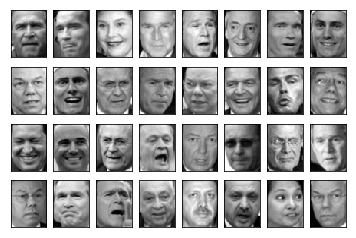

In [4]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2914-dimensional data to learn the fundamental relationships between the images. One useful way to start is to compute a PCA (it's even better to use the randomized PCA, that is, using randomized SVD and keeping only the most significant singular vectors to project the data to a lower dimensional space if the dataset is huge), and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

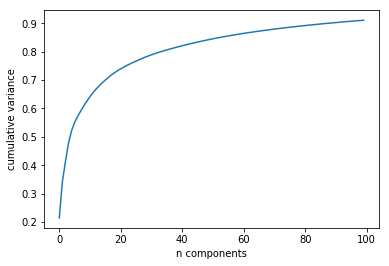

In [5]:
PCA_model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(PCA_model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components. When this is the case, nonlinear manifold embeddings can be helpful. We can compute an Isomap embedding on these faces using the same pattern shown before:

In [6]:
model = Isomap(n_components=2) # projecting onto 2 dimensions
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

The output is a two-dimensional projection of all the input images. To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

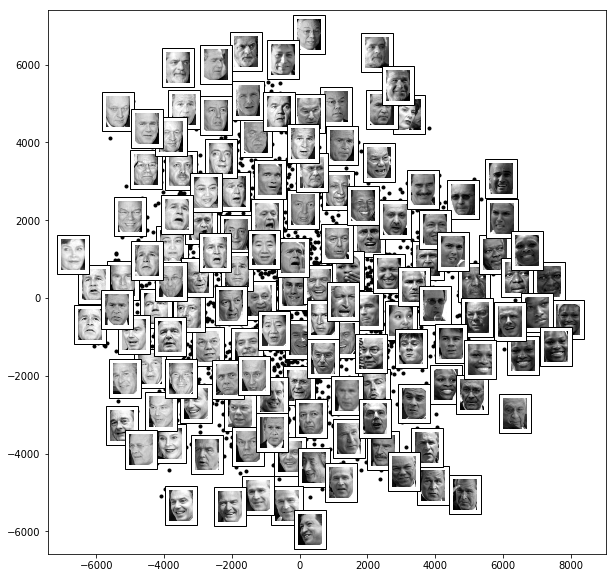

In [7]:
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top (facing left or right). This gives us a nice visual indication of some of the fundamental features in our data.

### II. Local Linear Embedding (LLE)

Local linear embedding is simlar to Isomap, but it attempts to preserve local neighborhood information on the Riemann manifold without estimating the true geodisic distances. But LLE preserves local properties of the underlying manifold, so it is less susceptible to introducing false connections in the graph and can successfully embed nonconvex manifold. However, like Isomap, it has difficulty with manifolds that contain holes as well.

The intuition behind the LLE algorithm is based on simple geometric interpretation.
Suppose we sample data $x_{i}$ from some smooth underlying manifold $\mathcal{M}$. Provided there is sufficient data (such that the manifold is well-sampled), we expect each data point and its neighbors
to lie on or close to a locally linear patch of the manifold. We can characterize the local geometry of these patches by linear coefficients that reconstruct each data point from its neighbors. To some extent, LLE can be thought of as a series of local principal component analysis which are globally compared to find the best nonlinear embedding.

The LLE algorithm consists of 3 steps:

##### Algorithm:
   1. Let $N(x_{i}, \mathcal{N})$ denote the 'neighborhood' of point $x_{i}$ that contains only its $\mathcal{N}$-nearest points as measured by Euclidean distances ($\mathcal{N}$ can even be different for each point $x_{i}$). In that case we will write $\mathcal{N_{i}}$. Fix $\mathcal{N} \in \mathbb{Z}$. The success of LLE depends on the choice of $\mathcal{N}$. This hyperparameter must be sufficient large so that hte points can be well-reconstructed but also sufficiently small for the manifold to have little curvature. 
   2. Reconstruct $x_{i}$ by a linear function of its $\mathcal{N}$-nearest neighbors so that $\hat{x}_{i}=\sum_{j=1}^{n}w_{ij}x_{j}$ where $w_{ij}$ is a scalar weight for $x_{j}$ with unit sum $\sum_{j=1}^{n}w_{ij}=1$ (for translation invariance). If $x_{l} \notin N(x_{i}, \mathcal{N})$, then we set $w_{il}=0$. Set $W=[w_{ij}]$ to be a sparse $n \times n$ matrix of weights (and there are only $n\mathcal{N}$ nonzero elements). Find optimal weights $\hat{w_{ij}}$ by minimizing the cost function $Q(w_{ij})=\sum_{i=1}^{n}||x_{i}-\sum_{j=1}^{n}w_{ij}x_{j}||^{2}$: $\hat{W} = \text{argmin}_{W}Q(w_{ij})$, subject to the invariance constraints $\sum_{j}w_{ij}=1$ and the sparness constraint $w_{il}=0$ if $x_{l} \notin N(x_{i}, \mathcal{N})$. This is a constrained least square fitting problem. It is possible show that the optimal value of $w_{i}=(w_{i1},w_{i2},...w_{in})'$ can be written as $\hat{w_{i}}=(\iota'U^{-1}\iota)^{-1}(U^{-1}\iota)$ where $\iota$ is a column vector of 1's (with dimension equal to $n$) and $U=[u_{jk}]$ with $u_{jl}=(x_{i}-x_{j})'(x_{i}-x_{l})$, with $j,l \in N(x_{i}, \mathcal{N})$. Notice that $U$ is a symmetric, nonnegative definite square matrix of size $n$ and $\hat{W}$ has only $(n\mathcal{N})$ nonzero elements. Note also that the constrained weights that minimize these reconstruction errors obey an
important symmetry: for any particular data point, they are invariant to rotations, rescalings, and translations of that data point and its neighbors. the invariance to translations is enforced by the sum-to-one constraint on the rows of the weight matrix. A consequence of this symmetry is that the reconstruction weights characterize intrinsic geometric properties of each neighborhood, as opposed to properties that depend on a particular frame of reference.
   3. Fix the optimal weight matrix $\hat{W}$ obtained above. Find the $(r \times n)$ matrix $Y=(y_{1},...y_{n})$, $r \ll K$, of embedding coordinates that solves $\hat{Y}=\text{argmin}_{Y}\sum_{i=1}^{n}||y_{i}-\sum_{j=1}^{n}\hat{w}_{ij}y_{j}||^{2}$ subject to the constraint $\sum_{i=1}^{n}y_{i}=Y\iota=0$ and $\frac{1}{n}\sum_{i=1}^{n}y_{i}y_{i}'=I_{r}$ where $I_{r}$ is the identity matrix of size $r$. These constraints are imposed to fix the translation, rotation and the scale of the embedding coordinates so that the objective function will be invariant. This problem can be rewritten as $\hat{Y}=\text{argmin}_{Y}\text{tr}(YMY')$ where $M=(I_{n}-\hat{W})'(I_{n}-\hat{W})$. The objective function $\text{tr}(YMY')$ has a unique global minimum given by the eigenvectors of corresponding to the smallest $r+1$ eigenvalues of $M$. Thus it can be shown that $\hat{Y}_{r \times n}=(\hat{y}_{1},\hat{y}_{2}...\hat{y}_{n})=(v_{n-1},v_{n-2},...v_{n-r})'$ where $v_{n-j}$ is the eigenvector corresponding to the $(j+1)\text{st}$ smallest eigenvalue of $M$. This step is also known as partial eigenvector decomposition.
   
One well-known issue with LLE is the regularization problem. When the number of neighbors is greater than the number of input dimensions, the matrix defining each local neighborhood is rank-deficient. To address this, standard LLE applies an arbitrary regularization parameter r, which is chosen relative to the trace of the local weight matrix. Though it can be shown formally that as r approaches 0, the solution converges to the desired embedding, there is no guarantee that the optimal solution will be found for. This problem manifests itself in embeddings which distort the underlying geometry of the manifold.

One method to address the regularization problem is to use multiple weight vectors in each neighborhood. This is the essence of **modified locally linear embedding (MLLE)**. MLLE can be performed with the same function for LLE, with the keyword 'method' equal to 'modified'. It requires the arguments to satisfy 'n_neighbors > n_components' additionally.

Now let's see an example of LLE using the 'Hello Curve':

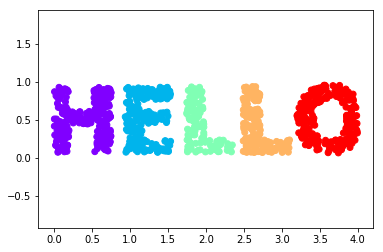

In [12]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

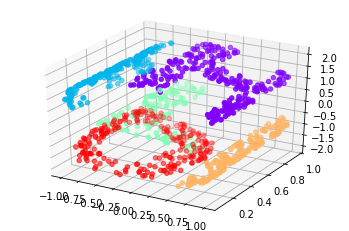

In [13]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

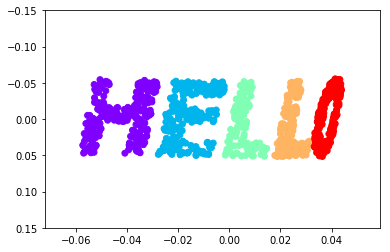

In [14]:
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, 
                               method='modified',eigen_solver='dense')
out = model.fit_transform(XS)
fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

Here are some common observations when we implement these algorithms based on our experience:
   1. In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA. Also it's hard to interpret the meaning of the manifold learning output compared to what we can say about PCA results. 
   2. In manifold learning, the presence of noise in the data can 'short-circuit' the manifold and drastically change the embedding. But PCA naturally filters noise from the most important components. 
   3. Manifold learning requires the number of neighbors to be chosen cleverly and it's sensitive to that hyperparameter. PCA doesn't involve such choice. 

### III. Hessian Eigenmapping (HE) 

Hessian eigenmapping (HE) is also known as Hessian-based local linear embedding (HLLE). It can be considered as a variant of the LLE, solving the regularization problem of LLE. It revolves around a Hessian-based quadratic form at each neighborhood which is used to recover the locally linear structure. Though other implementations note its poor scaling with data size, the 'sklearn' package implements some algorithmic improvements which make its cost comparable to that of other LLE variants for small output dimension. HLLE can be performed with the same function for LLE, with the keyword 'method' equal to 'hessian'. It requires 'n_neighbors>n_components*(n_components+3)/2'.

The motivation of Hessian eigenmapping comes from recovering manifolds of high-dimensional libraries of articulated images where the convexity assumption is often violated (Donoho and Grimes, 2003). Assume the parameter space $\Theta \subset \mathbb{R}^{r}$ and $\varphi: \Theta \longrightarrow \mathcal{X} \subseteq \mathbb{R}^{K}$ with $r<K$. Assume that $\mathcal{M}=\varphi(\Theta)$ is a smooth manifold of articulated images. The isometry and convexity requiremens of Isomap are replaced by the following weaker requirements:

##### Assumptions:
   1. Local Isometry: $\varphi(.)$ is a locally isometric embedding of $\Theta$ into $\mathbb{R}^{K}$. For any point $z$ in a sufficiently small neighborhood around each point $x$ on the manifold $\mathcal{M}$, the geodesic distance equals the Euclidean distance between their corresponding parameter points $\theta, \theta_{z} \in \Theta$, that is, $\rho(x,z)=||\theta-\theta_{z}||_{\Theta}$ where $x=\varphi(\theta)$, $z=\varphi(\theta_{z})$.
   2. Connectedness: the parameter space $\Theta$ is an open, connected subset of $\mathbb{R}^{r}$.

The goal is to recover the parameter vector $\theta$ up to a rigid motion (rigid motion means when a point or object is moved, but the size and shape remain the same; this differs from non-rigid motion, such as dilation, where the size of the object can increase or decrease). We will omit the details of the algorithm but it's very similar to LLE except step 2. Interested readers can reference the standard textbook by Izenman (2008) for more details. The book also discusses other types of manifold learning techniques in the same flavor of LLE, such as Laplacian eigenmaps (LE). Python also has implementations for LE. However, HLLE is the only method that can handle non-convexity assumptions so far among all the known algorithms for manifold learning. 

References:
   - https://blog.paperspace.com/dimension-reduction-with-isomap/
   - https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
   - https://prateekvjoshi.com/2014/06/21/what-is-manifold-learning/
   - https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
   - https://cs.nyu.edu/~roweis/lle/
   - Izenman, A.J. (2008). "Multivariate Statistical Techniques: Regression, Classfication, and Manifold Learning". Springer.
   - Berstein, M., de Silva, V., Langford, J.C. and Tenenbaum, J.B. (2000). Graph approximations to geodesics on embedded manifolds. Unpublished Technical Report, Stanford University. 
   - Floyd, R.W. (1962). Algorithm 97, Communications of the ACM, 5, 345.
   - Donoho, D. and Grimes, C. (2003). Hessian eigenmaps: locally linear embedding techniques for high-dimensional data, Proceedings of the National Academy of Sciences, 100, 5591-5596.